In [6]:
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
df = pd.read_csv('/Users/snehanarayanan/Documents/subscription_log project/netflix_revenue_updated-3.csv')
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%y")

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date                            24 non-null     datetime64[ns]
 1   Global Revenue                  24 non-null     int64         
 2   UCAN Streaming Revenue          24 non-null     int64         
 3   EMEA Streaming Revenue          24 non-null     int64         
 4   LATM Streaming Revenue          24 non-null     int64         
 5   APAC Streaming Revenue          24 non-null     int64         
 6   UCAN Members                    24 non-null     int64         
 7   EMEA  Members                   24 non-null     int64         
 8   LATM Members                    24 non-null     int64         
 9   APAC Members                    24 non-null     int64         
 10  UCAN ARPU                       24 non-null     float64       
 11  EMEA ARP

## EDA

In [7]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Simple Time Series Line Plots
def plot_time_series(df, column, title):
    plt.figure(figsize=(12, 4))
    plt.plot(df['Date'], df[column], marker='o', linestyle='-')
    plt.title(f"{title} Over Time")
    plt.xlabel("Date")
    plt.ylabel(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

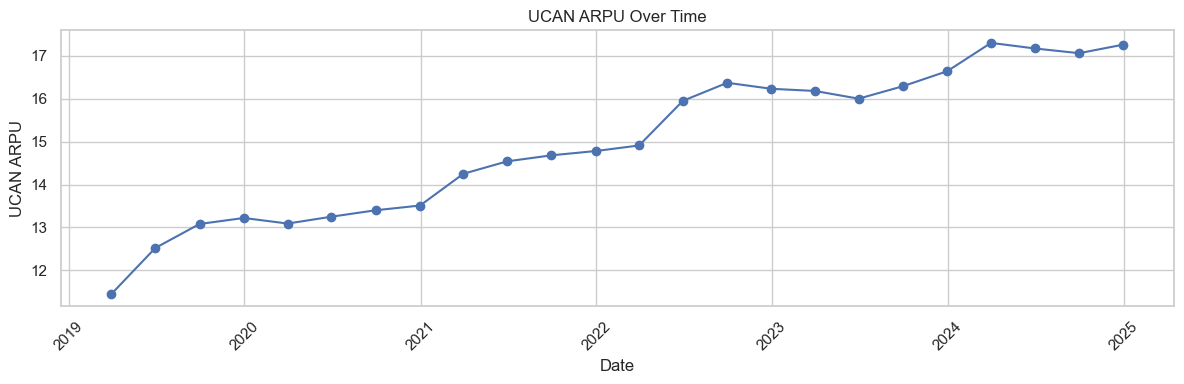

In [8]:
plot_time_series(df, 'UCAN ARPU', 'UCAN ARPU')


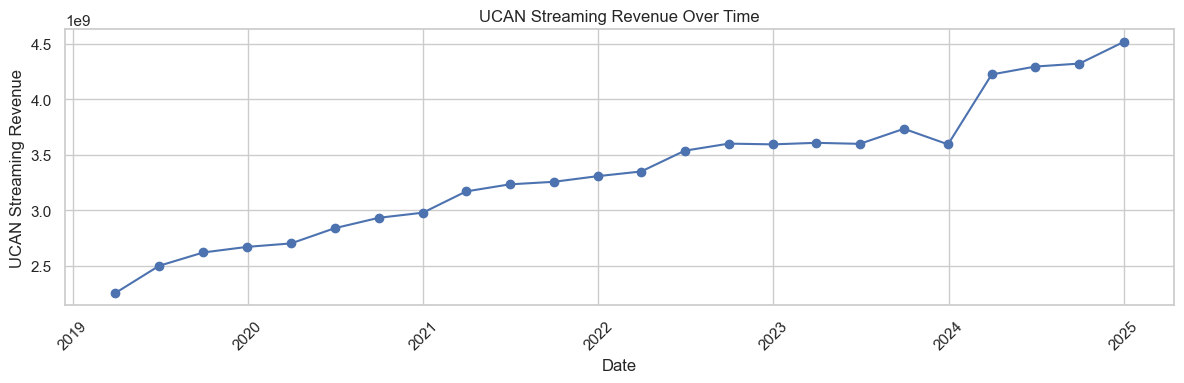

In [9]:

# Plot UCAN Streaming Revenue
plot_time_series(df, 'UCAN Streaming Revenue', 'UCAN Streaming Revenue')

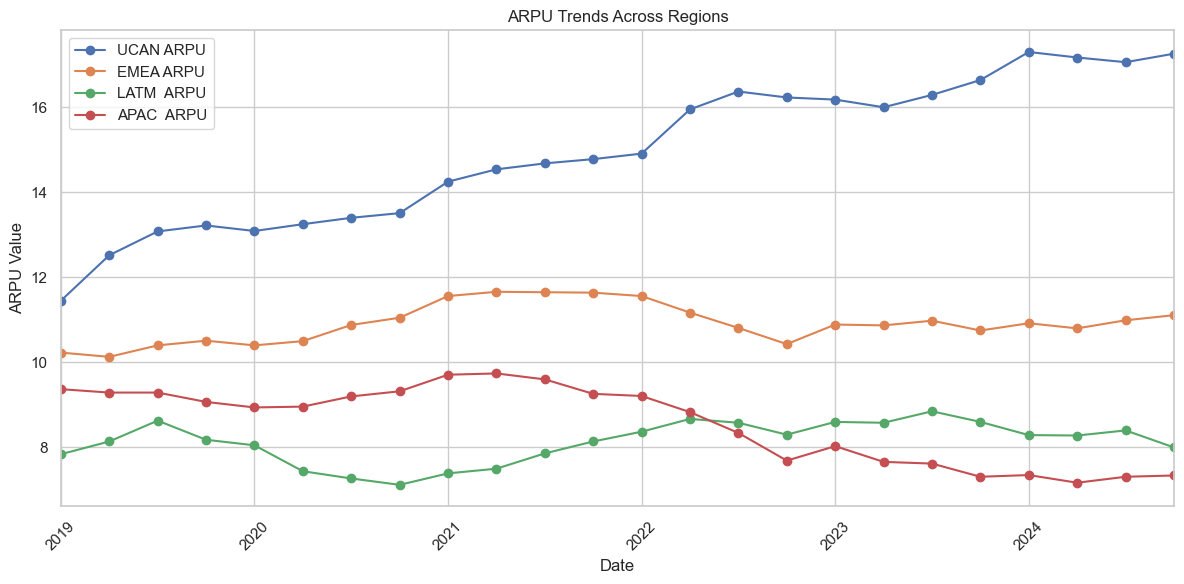

In [10]:
arpus = [col for col in df.columns if 'ARPU' in col]
df_arpus = df[['Date'] + arpus].dropna()
df_arpus.set_index('Date').plot(marker='o')
plt.title("ARPU Trends Across Regions")
plt.ylabel("ARPU Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

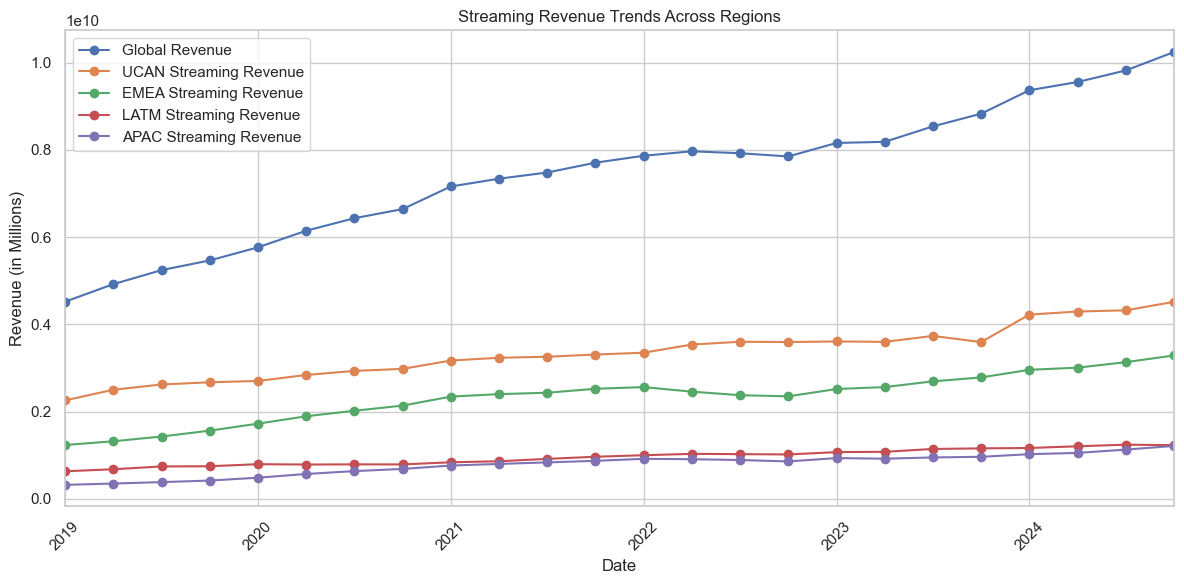

In [11]:
revenues = [col for col in df.columns if 'Revenue' in col]
df_revs = df[['Date'] + revenues].dropna()
df_revs.set_index('Date').plot(marker='o')
plt.title("Streaming Revenue Trends Across Regions")
plt.ylabel("Revenue (in Millions)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Forecasting ARPU 

In [24]:
df

,Date,Global Revenue,UCAN Streaming Revenue,EMEA Streaming Revenue,LATM Streaming Revenue,APAC Streaming Revenue,UCAN Members,EMEA Members,LATM Members,APAC Members,UCAN ARPU,EMEA ARPU,LATM ARPU,APAC ARPU,Netflix Streaming Memberships
0,2019-03-31,4520992000,2256851000,1233379000,630472000,319602000,66633000,42542000,27547000,12141000,11.45,10.23,7.84,9.37,148863000
1,2019-06-30,4923116000,2501199000,1319087000,677136000,349494000,66501000,44229000,27890000,12942000,12.52,10.13,8.14,9.29,151562000
2,2019-09-30,5244905000,2621250000,1428040000,741434000,382304000,67114000,47355000,29380000,14485000,13.08,10.40,8.63,9.29,158334000
3,2019-12-31,5467434000,2671908000,1562561000,746392000,418121000,67662000,51778000,31417000,16233000,13.22,10.51,8.18,9.07,167090000
4,2020-03-31,5767691000,2702776000,1723474000,793453000,483660000,69969000,58734000,34318000,19835000,13.09,10.40,8.05,8.94,182856000
5,2020-06-30,6148286000,2839670000,1892537000,785368000,569140000,72904000,61483000,36068000,22492000,13.25,10.50,7.44,8.96,192947000
6,2020-09-30,6435637000,2933445000,2019083000,789384000,634891000,73081000,62242000,36324000,23504000,13.40,10.88,7.27,9.20,195151000
7,2020-12-31,6644442000,2979505000,2137158000,788522000,684609000,73936000,66698000,37537000,25492000,13.51,11.05,7.12,9.32,203663000
8,2021-03-31,7163282000,3170972000,2343674000,836647000,762414000,74384000,68508000,37894000,26853000,14.25,11.56,7.39,9.71,207639000
9,2021-06-30,7341777000,3234643000,2400480000,860882000,799480000,73951000,68696000,38658000,27875000,14.54,11.66,7.50,9.74,209180000


In [26]:
df_arpu = df[['Date', 'UCAN ARPU']].dropna().copy()

In [31]:
df_arpu

,UCAN ARPU
Date,
2019-03-31,11.45
2019-06-30,12.52
2019-09-30,13.08
2019-12-31,13.22
2020-03-31,13.09
2020-06-30,13.25
2020-09-30,13.40
2020-12-31,13.51
2021-03-31,14.25


In [18]:
df_prophet

,y
Date,
2019-03-31,11.45
2019-06-30,12.52
2019-09-30,13.08
2019-12-31,13.22
2020-03-31,13.09
2020-06-30,13.25
2020-09-30,13.40
2020-12-31,13.51
2021-03-31,14.25


In [28]:
df_prophet = df_arpu.rename(columns={'Date': 'ds', 'UCAN ARPU': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=4, freq='Q')
forecast_prophet = model_prophet.predict(future)
arpu_forecast_prophet = forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
arpu_prophet_q1_2025 = arpu_forecast_prophet[arpu_forecast_prophet['ds'] == '2025-03-31']['yhat'].values[0]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
/Users/snehanarayanan/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


In [30]:
df_arpu_arima = df_arpu.set_index('Date')
model_arima = ARIMA(df_arpu_arima['UCAN ARPU'], order=(1, 1, 1))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=4)
arpu_arima_q1_2025 = forecast_arima.iloc[0]

KeyError: "None of ['Date'] are in the columns"

In [15]:
df_xgb = df_arpu.reset_index()
for lag in range(1, 5):
    df_xgb[f'lag_{lag}'] = df_xgb['UCAN ARPU'].shift(lag)
df_xgb.dropna(inplace=True)

X = df_xgb.drop(columns=['Date', 'UCAN ARPU'])
y = df_xgb['UCAN ARPU']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=4)

model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)

last_known = X.iloc[-1].values.reshape(1, -1)
forecast_xgb = []
for _ in range(4):
    pred = model_xgb.predict(last_known)[0]
    forecast_xgb.append(pred)
    last_known = np.roll(last_known, 1)
    last_known[0, 0] = pred

forecast_arpu_xgb = forecast_xgb[0]

## Forecast UCAN Streaming Revenue (Q1 2025)